In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

### Recurrent Neural Network 

Neural Networks can be two types:
1. **Feed-Forward Network** - These networks use information from the current state to process for the next state.
2. **Recurrent Network** - These networks not just use the information from current state but from previous states to process for next state. They keep a memory storing important information from previous states.

In this notebook, we will train an RNN to predict **'ihello'** from **'hihell'**.
1. The letters will be given as inputs one-by-one (or multiple together).
2. At any instant, the RNN takes an input character and outputs two variables:
    1. Output character: Prediction for the current instance.
    2. Hidden state: This is to be used for the next instance. This way the information from previous states keep propagating forward.

We'll create a Recurrent Neural Network class **RNN**, from scratch that we'll use for training.

In [2]:
chars = ['h','i','e','l','o']
char2int = dict(zip(chars, range(len(chars))))
int2char = {v:k for k,v in char2int.items()}
OHE_mat = np.identity(len(chars))

In [3]:
input_word = 'hihell'
output_word = 'ihello'
X = np.array(list(map(lambda x: OHE_mat[char2int[x]], list(input_word)))).astype('int')
Y = np.array(list(map(lambda x: OHE_mat[char2int[x]], list(output_word)))).astype('int')
X.shape, Y.shape

((6, 5), (6, 5))

#### Training a Neural Network

The steps for training a neural network are as follows:
1. **Training:**
    1. Split data into training and validation sets
    2. Initialize random weights and biases
    3. For an epoch:
        1. For each batch:
            1. **Forward Pass:** Propagate through the network and calculate loss
            2. **Backward Pass (Back-Propagation):**
                1. Back-propagate through the network to calculate gradient of loss with respect to weights and biases
                2. Update the weights and biases using an optimizer 
        2. Calculate mean training loss across all batches for the epoch
        3. Calculate validation loss with final weights and biases at end of epoch
    4. Repeat step 3 for significant number of epochs until loss convergence
2. **Inference:**
    1. Using final weights and biases, predict on testing data 

#### Forward Equations:

$$
\begin{aligned}
Z_{1} &=H W_{1}+X W_{2}+B_{1} \\
Y_{1} &=\operatorname{tanh}\left(Z_{1}\right) \\
Z_{2} &=Y_{1} W_{3}+B_{2} \\
\hat{y} &=\operatorname{softmax}\left(Z_{2}\right)
\end{aligned}
$$

#### Backward Equations:
$$
\begin{aligned}
&d Z_{2}=\frac{\partial L}{\partial Z_{2}}=\hat{y}-y \\
&d Y_{1}=\frac{\partial L}{\partial Y_{1}}=d Z_{2} W_{3}^{\top} \\
&d W_{3}=\frac{\partial L}{\partial W_{3}}=Y_{1}^{\top} d Z_{2} \\
&d Z_{1}=d Y_{1}\left(1-\tanh ^{2}\left(Y_{1}\right)\right) \\
&d W_{1}=H^{\top} d Z_{1} \\
&d W_{2}=X^{\top} d Z_{1} \\
&d B_{1}=d Z_{1} 1 \\
&d B_{2}=d Z_{2} 1
\end{aligned}
$$

In [4]:
class RNN:
    def __init__(self, n_input, n_hidden, n_output, alpha, batch_size):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output

    def initialize_weights(self, batch_size):
        self.W1 = np.random.normal(-1, 1, size=(self.n_hidden, self.n_hidden))
        self.W2 = np.random.normal(-1, 1, size=(self.n_input, self.n_hidden))
        self.W3 = np.random.normal(-1, 1, size=(self.n_hidden, self.n_output))
        self.B1 = np.random.normal(-1, 1, size=(batch_size, 1))
        self.B2 = np.random.normal(-1, 1, size=(batch_size, 1))
        self.X_hidden_init = np.random.random(size=(batch_size, self.n_hidden))

    def tanh(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def dtanh(self, x):
        return 1 - self.tanh(x)**2

    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1,1)      

    def cross_entropy_loss(self, y_batch, y_score):
        return -np.sum(np.multiply(y_batch, np.log(y_score))) / len(y_batch)    

    def forward(self, X_hidden, X_batch, y_batch):
        Z1 = X_hidden @ self.W1 + X_batch @ self.W2 + self.B1
        Y1 = self.tanh(Z1)
        Z2 = Y1 @ self.W3 + self.B2
        y_score = self.softmax(Z2)
        L = self.cross_entropy_loss(y_batch, y_score)
        return Z1, Y1, Z2, y_score, L   

    def gradient(self, Z1, Y1, Z2, y_score, X_hidden, X_batch, y_batch):
        dZ2 = (y_score - y_batch) / len(y_batch)
        dY1 = dZ2 @ self.W3.T
        dZ1 = dY1 * self.dtanh(Y1)

        self.dW3 = Y1.T @ dZ2
        self.dW2 = X_batch.T @ dZ1
        self.dB2 = dZ2 @ np.ones(shape=(self.n_output,1))
        self.dW1 = X_hidden.T @ dZ1
        self.dB1 = dZ1 @ np.ones(shape=(self.n_hidden,1))

        assert dZ2.shape == Z2.shape
        assert dY1.shape == Y1.shape
        assert dZ1.shape == Z1.shape

        assert self.dW3.shape == self.W3.shape
        assert self.dW2.shape == self.W2.shape
        assert self.dB2.shape == self.B2.shape
        assert self.dW1.shape == self.W1.shape
        assert self.dB1.shape == self.B1.shape

    def updates(self, alpha):
        self.W1 = self.W1 - alpha * self.dW1
        self.W2 = self.W2 - alpha * self.dW2
        self.W3 = self.W3 - alpha * self.dW3
        self.B1 = self.B1 - alpha * self.dB1
        self.B2 = self.B2 - alpha * self.dB2

    def backward(self, Z1, Y1, Z2, y_score, X_hidden, X_batch, y_batch, alpha):
        self.gradient(Z1, Y1, Z2, y_score, X_hidden, X_batch, y_batch)
        self.updates(alpha)

    def train(self, X, Y, alpha, batch_size):
        n_examples = X.shape[0]
        X_hidden = self.X_hidden_init
        batch_runs = int(n_examples / batch_size)
        loss = 0
        pred_string = []

        for batch_idx in range(batch_runs):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, n_examples)
            X_batch = X[batch_start:batch_end]
            y_batch = Y[batch_start:batch_end]

            Z1, Y1, Z2, y_score, L = self.forward(X_hidden, X_batch, y_batch)
            self.backward(Z1, Y1, Z2, y_score, X_hidden, X_batch, y_batch, alpha)

            pred_chars = self.predict(y_score)
            X_hidden = Y1
            loss += L
            pred_string.append(pred_chars)

        pred_string = list(itertools.chain(*pred_string))
        mean_loss = loss / batch_runs
        return mean_loss, pred_string

    def predict(self, y_score):
        pred = np.flip(np.argsort(y_score, axis=1), axis=1)[:,0]
        pred_chars = list(map(lambda x: int2char[x], pred))
        return pred_chars

### Training RNN

We initialize the class specifying all the parameters and train the model over a sufficient number of epochs.

#### Important Points:
1. The batch size can be 1 or more, depending on the number of characters you want to feed together.
2. The hidden state has no dependence on input/output dimensions or number of class labels (characters).

In [5]:
alpha = 0.05 
num_epochs = 1000
num_classes = 5
n_input = num_classes
n_hidden = 3
n_output = num_classes
batch_size = 1

model = RNN(n_input, n_hidden, n_output, alpha, batch_size)
history = {}
for epoch_idx in range(1, num_epochs+1):
    if epoch_idx==1:
        model.initialize_weights(batch_size)
    loss, pred_string = model.train(X, Y, alpha, batch_size)
    pred_string = ''.join(pred_string)

    if epoch_idx % 50 ==0:
        print(f'Epoch: {epoch_idx} | Loss: {loss.round(3)} | Prediction String: {pred_string}')
    
    history[epoch_idx]= loss

Epoch: 50 | Loss: 0.845 | Prediction String: ehloll
Epoch: 100 | Loss: 0.499 | Prediction String: ihelll
Epoch: 150 | Loss: 0.375 | Prediction String: ihelol
Epoch: 200 | Loss: 0.358 | Prediction String: iheloo
Epoch: 250 | Loss: 0.346 | Prediction String: iheloo
Epoch: 300 | Loss: 0.182 | Prediction String: ihello
Epoch: 350 | Loss: 0.153 | Prediction String: ihello
Epoch: 400 | Loss: 0.084 | Prediction String: ihello
Epoch: 450 | Loss: 0.071 | Prediction String: ihello
Epoch: 500 | Loss: 0.355 | Prediction String: ihelll
Epoch: 550 | Loss: 0.205 | Prediction String: ihello
Epoch: 600 | Loss: 0.093 | Prediction String: ihello
Epoch: 650 | Loss: 0.049 | Prediction String: ihello
Epoch: 700 | Loss: 0.037 | Prediction String: ihello
Epoch: 750 | Loss: 0.028 | Prediction String: ihello
Epoch: 800 | Loss: 0.023 | Prediction String: ihello
Epoch: 850 | Loss: 0.019 | Prediction String: ihello
Epoch: 900 | Loss: 0.017 | Prediction String: ihello
Epoch: 950 | Loss: 0.015 | Prediction String: i

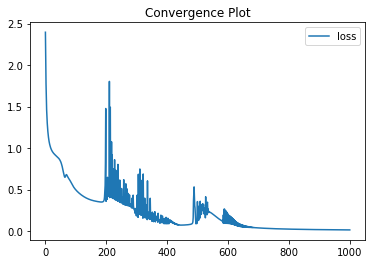

In [6]:
losses = list(history.values())
plt.title('Convergence Plot')
plt.plot(losses, label='loss')
plt.legend()
plt.show()